# HSCT survival: linear regression model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-no_multicollinearity_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
poly_training_features_data_file=f'{config.DATA_PATH}/processed/03.1-polynomial_training_features_df.parquet'
poly_testing_features_data_file=f'{config.DATA_PATH}/processed/03.1-polynomial_testing_features_df.parquet'

# Model files
model_file=f'{config.MODELS_PATH}/03.1-linear_regression.pkl'
poly_model_file=f'{config.MODELS_PATH}/03.1-linear_regression_polynomial_features.pkl'
poly_features_transformer_file=f'{config.MODELS_PATH}/03.1-poly_features_transformer.pkl'

# Scoring results
model_scores_file=f'{config.DATA_PATH}/results/data/03.1-model_scores.pkl'

retrain_models=True
rebuild_poly_features=True

## 1. Load data

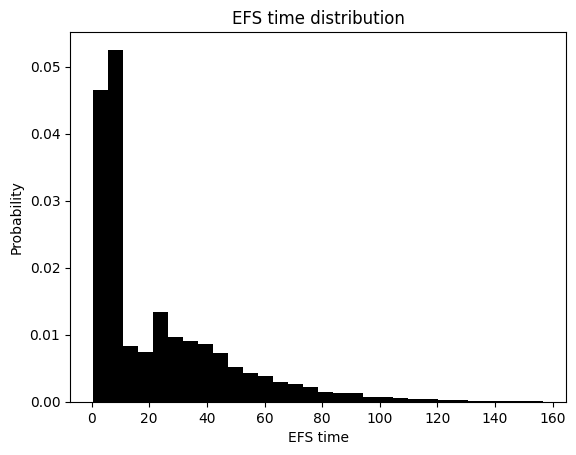

Training features: (28800, 118)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

## 2. Data preparation

### 2.1. Train-test split

In [3]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

### 2.2. Save and remove training & testing race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Make features and labels

In [5]:
training_labels_df=training_df[['efs', 'efs_time']].copy()
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
training_labels_df['sqrt_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/training_labels_df['efs_time']

testing_labels_df=testing_df[['efs', 'efs_time']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels_df['sqrt_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/testing_labels_df['efs_time']

### 2.4. Standard scale features

In [6]:
scaler=StandardScaler()
scaler.fit(training_features_df)

training_index=training_features_df.index
testing_index=testing_features_df.index

training_features=scaler.transform(training_features_df)
testing_features=scaler.transform(testing_features_df)

training_features_df=pd.DataFrame(training_features, columns=training_features_df.columns)
testing_features_df=pd.DataFrame(testing_features, columns=testing_features_df.columns)

training_features_df.set_index(training_index, inplace=True)
testing_features_df.set_index(testing_index, inplace=True)

## 3. Models

In [7]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

### 3.1. Linear regression model

Label type: efs_time


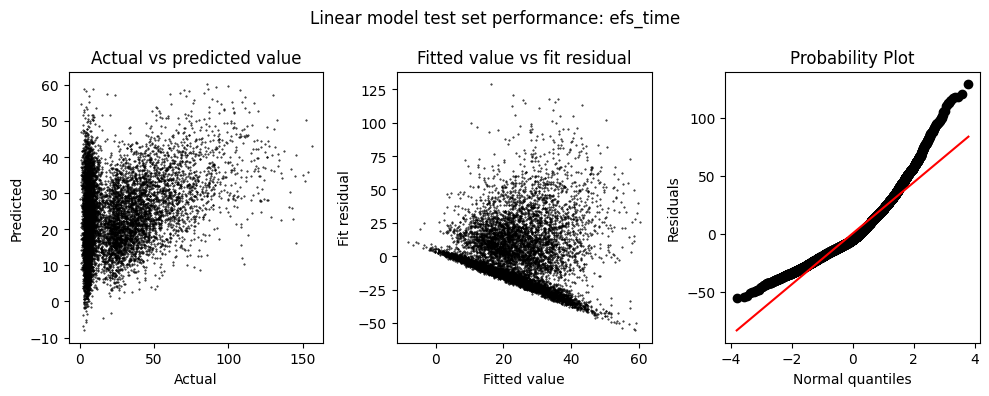

Label type: log_efs_time


<Figure size 640x480 with 0 Axes>

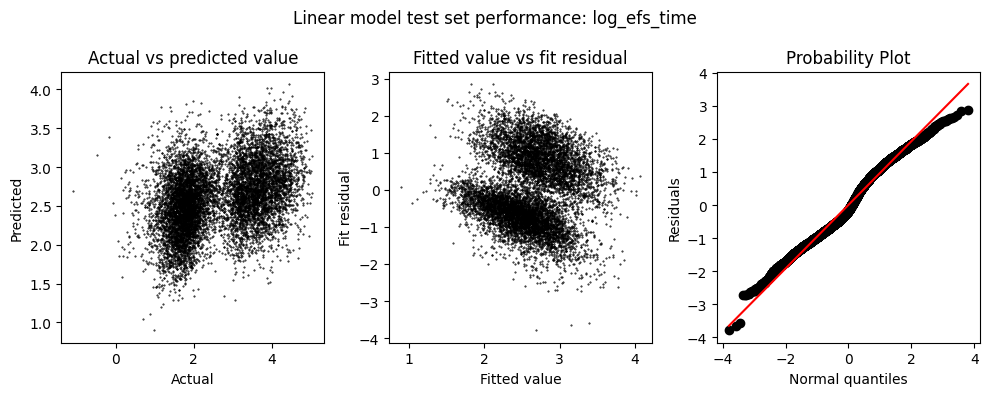

Label type: sqrt_efs_time


<Figure size 640x480 with 0 Axes>

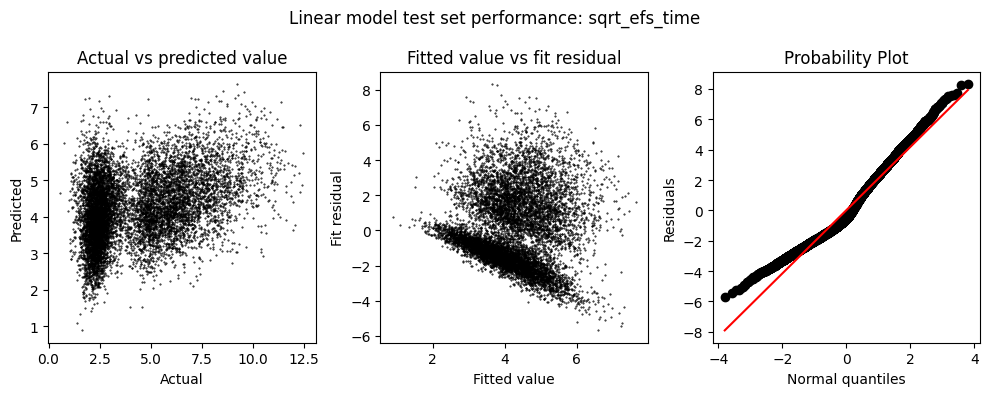

Label type: reciprocal_efs_time


<Figure size 640x480 with 0 Axes>

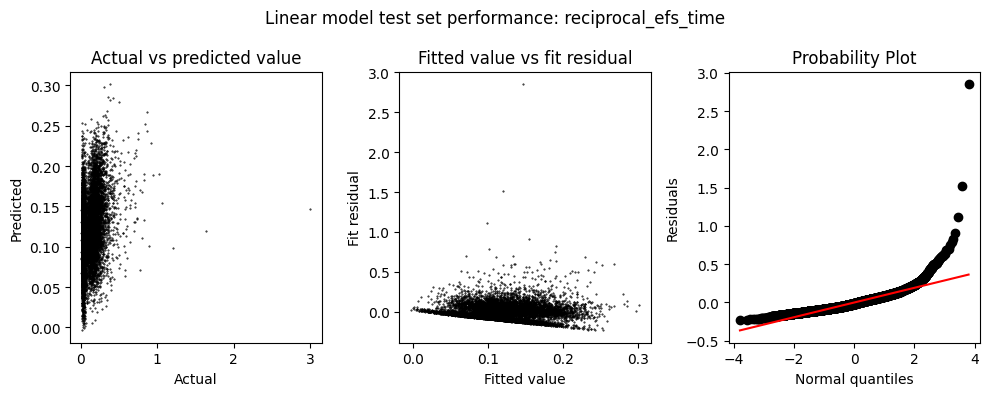

<Figure size 640x480 with 0 Axes>

In [ ]:
label_types=['efs_time', 'log_efs_time', 'sqrt_efs_time', 'reciprocal_efs_time']

for label_type in label_types:

    print(f'Label type: {label_type}')

    # Train or load model as desired
    if retrain_models == True:

        model=LinearRegression()
        model.fit(training_features_df, training_labels_df[label_type])

        with open(model_file, 'wb') as output_file:
            pickle.dump(model, output_file)

    elif retrain_models == False:
        with open(model_file, 'rb') as input_file:
            model=pickle.load(input_file)

    # Make predictions for the test set
    predicted_efs_time=model.predict(testing_features_df)

    # Score the predictions
    scoring_results=helper_funcs.score_predictions(
        model_description=f'Linear, {label_type} label',
        predictions=predicted_efs_time,
        labels_df=testing_labels_df,
        race_group=testing_race_group,
        results=scoring_results,
        label_type=label_type
    )

    plot=plot_funcs.prediction_eval_plot(
        f'Linear model test set performance: {label_type}',
        predicted_efs_time,
        testing_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(f'{config.DATA_PATH}/results/plots/03.1-performance_linear_model_{label_type}.jpg', dpi=300)
    plot.show()

### 3.2. Linear regression: polynomial features

#### 3.2.1. Make/load polynomial features

In [9]:
# Build or load polynomial features as desired
if rebuild_poly_features == True:

    # Fit polynomial feature transformer on training data
    poly=PolynomialFeatures(2, interaction_only=True, include_bias=False)
    poly.fit(training_features_df)

    # Create polynomial interaction features for training and testing data
    poly_training_data=poly.transform(training_features_df)
    poly_testing_data=poly.transform(testing_features_df)

    # Convert new features into dataframes
    poly_interaction_training_features_df=pd.DataFrame(poly_training_data)
    poly_interaction_testing_features_df=pd.DataFrame(poly_testing_data)

    # Make the column names string
    poly_interaction_training_features_df.columns=poly_interaction_training_features_df.columns.astype(str)
    poly_interaction_testing_features_df.columns=poly_interaction_testing_features_df.columns.astype(str)
    print(f'Training data interaction features: {poly_interaction_training_features_df.shape}')

    # Add the interaction features back to the original features
    poly_training_features_df=pd.concat([
        poly_interaction_training_features_df.reset_index(drop=True),
        training_features_df.reset_index(drop=True)
    ],axis=1)

    poly_training_features_df.index=training_features_df.index

    poly_testing_features_df=pd.concat([
        poly_interaction_testing_features_df.reset_index(drop=True),
        testing_features_df.reset_index(drop=True)
    ],axis=1)

    poly_testing_features_df.index=testing_features_df.index

    # Save the polynomial features
    poly_training_features_df.to_parquet(poly_training_features_data_file)
    poly_testing_features_df.to_parquet(poly_testing_features_data_file)

    # Save the polynomial feature transformer
    with open(poly_features_transformer_file, 'wb') as output_file:
        pickle.dump(poly, output_file)

elif rebuild_poly_features == False:

    poly_training_features_df=pd.read_parquet(poly_training_features_data_file)
    poly_testing_features_df=pd.read_parquet(poly_testing_features_data_file)

    with open(poly_features_transformer_file, 'rb') as input_file:
        poly=pickle.load(input_file)

print(f'Polynomial training data: {poly_training_features_df.shape}')

Training data interaction features: (19296, 6670)
Polynomial training data: (19296, 6785)


In [10]:
poly_interaction_training_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669
0,-0.914704,0.208502,0.215701,0.245271,0.196735,0.613531,0.203664,0.094715,0.192290,-0.446851,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
1,0.563738,-0.606802,-1.864081,-0.974242,-0.927500,-1.768693,-1.893305,0.571033,-1.642515,-1.937764,...,-0.740853,-1.465628,-0.206220,-0.420820,1.429417,0.201125,0.410423,0.397886,0.811939,0.114243
2,0.563738,0.752038,0.735646,0.767920,0.758853,0.613531,0.727906,0.571033,0.650992,0.547090,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
3,0.563738,0.752038,0.735646,0.767920,0.758853,0.613531,0.727906,0.571033,0.192290,0.547090,...,-0.740853,0.518290,-0.206220,-0.420820,-0.505485,0.201125,0.410423,-0.140704,-0.287126,0.114243
4,0.563738,0.072618,-0.997505,-0.103161,0.196735,0.613531,-0.145831,0.571033,0.650992,0.547090,...,-1.349795,-0.682302,0.271478,0.553987,0.699586,-0.278355,-0.568021,-0.140704,-0.287126,0.114243


#### 3.2.2. Test set performance

In [ ]:
label_types=['efs_time', 'log_efs_time', 'sqrt_efs_time', 'reciprocal_efs_time']

for label_type in label_types:

    print(f'Label type: {label_type}')

    # Train or load model as desired
    if retrain_models == True:
        poly_model=LinearRegression()
        poly_model.fit(poly_training_features_df, training_labels_df[label_type])

        with open(poly_model_file, 'wb') as output_file:
            pickle.dump(poly_model, output_file)

    elif retrain_models == False:
        with open(poly_model_file, 'rb') as input_file:
            poly_model=pickle.load(input_file)

    # Make predictions on the training set
    poly_predicted_efs_time=poly_model.predict(poly_testing_features_df)

    scoring_results=helper_funcs.score_predictions(
        model_description=f'Polynomial, {label_type} label',
        predictions=poly_predicted_efs_time,
        labels_df=testing_labels_df,
        race_group=testing_race_group,
        results=scoring_results,
        label_type=label_type
    )

    plot_funcs.prediction_eval_plot(
        f'Polynomial model test set performance: {label_type}',
        poly_predicted_efs_time,
        testing_labels_df[label_type]
    ).show()

    # Save the plot
    plt.savefig(f'{config.DATA_PATH}/results/plots/03.1-performance_polynomial_model_{label_type}.jpg', dpi=300)

Label type: efs_time


## 4. Model comparison

In [ ]:
scoring_results_df=pd.DataFrame.from_dict(scoring_results)
scoring_results_df.to_csv(model_scores_file, index=False)
scoring_results_df.head()